In [1]:
from tqdm import tqdm
import pandas as pd
import torchaudio
import librosa
import shutil
import json
import os

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=8, progress_bar=True)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
audio_dir = "/data/audio_data/prep_submission_audio/12/"
metadata_path = "../prep_data/raw_jsonl/train-data-type-12-v2.jsonl"

# audio_dir = "/data/audio_data/prep_submission_audio/12/"
# metadata_path = "../prep_data/raw_jsonl/train_data_type_12.jsonl"

with open(metadata_path, "r", encoding="utf-8") as f:
    content = f.readlines()
    lines = [json.loads(line.strip()) for line in content]
    data = pd.DataFrame(lines)
print(data.shape)
data.head(2)

(133407, 13)


,id,raw,text,utt_id,start_time,end_time,arpas,trans,phone_scores,word_scores,decisions,word_ids,utterance_scores
0,5107058,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[94, 0, 0, 100, 99, 94, 68]",[59],"[2, 0, 0, 2, 2, 2, 1]","[0, 0, 0, 0, 0, 0, 0]",59.0
1,1590011,Depressed,DEPRESSED,None,None,None,"[D, IH0, P, R, EH1, S, T]","[D, IH, P, R, EH, S, T]","[98, 23, 92, 100, 99, 95, 93]",[87],"[2, 0, 2, 2, 2, 2, 2]","[0, 0, 0, 0, 0, 0, 0]",87.0


In [3]:
data["audio_path"] = data.id.apply(lambda x: os.path.join(audio_dir, f'{x}.wav'))

In [4]:
import torchaudio

def check_audio(path, min_duration=1.0):    
    try:
        wav, sr = librosa.load(path, sr=16000)   

        if wav.shape[0] / sr < min_duration:
            return False 
    except:
        return False
    
    return True
    
is_success = data.parallel_apply(lambda x: check_audio(x["audio_path"]), axis=1)
print(is_success[is_success==False].shape)
print(is_success[is_success==True].shape)

(0,)
(133407,)


In [5]:
data = data[is_success==True]

<Axes: >

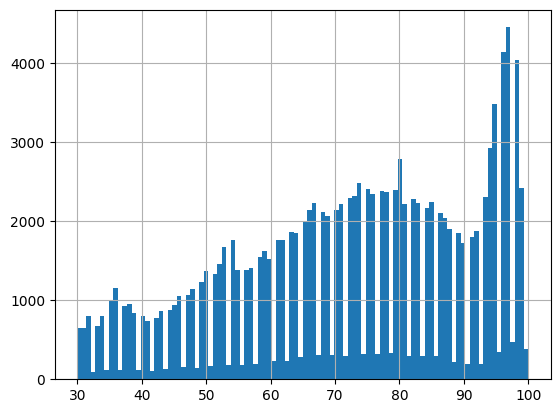

In [6]:
data.utterance_scores.hist(bins=100)

In [7]:
data[["id", "text"]].to_csv("../prep_data/csv/train-data-type-12-v2.csv", sep="|", index=None, header=None)

In [8]:
extracted_data = data[is_success == True]
path = "../prep_data/jsonl/train-data-type-12-v2.jsonl"
with open(path, "w", encoding="utf-8") as f:
    for index in tqdm(extracted_data.index):
        sample = extracted_data.loc[index].to_dict()
        json_obj = json.dumps(sample)

        f.write(f'{json_obj}\n')

  9%|▊         | 11457/133407 [00:00<00:04, 28611.21it/s]

100%|██████████| 133407/133407 [00:04<00:00, 28900.23it/s]
